# ACS in Mountain Car environment

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import random
import pickle

import pandas as pd
import numpy as np

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../openai-envs'))

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.metrics import population_metrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

# Load gyms
import gym
import gym_mountain_car

In [2]:
# papermill params
trials = 15000
decay = True
bins = [10, 20]
biased_exploration=0
gamma = 0.95 # that might be important since the reward is far away

## Environment
Description - https://github.com/openai/gym/wiki/MountainCar-v0

![aa](http://gym.openai.com/v2018-02-21/videos/MountainCar-v0-270f34b9-f23e-4d95-a933-4c902b4f4435/poster.jpg)

In [3]:
env = gym.make('EnergyMountainCar-v0')
env._max_episode_steps = 1000

_range, _low = (env.observation_space.high - env.observation_space.low, env.observation_space.low)

## Agent configuration

### Discretization of continuous input

In [4]:
class MountainCarAdapter(EnvironmentAdapter):
    BINS = np.array(bins)
    
    @classmethod
    def to_genotype(cls, obs):
        r = (obs + np.abs(_low)) / _range
        b = (r * cls.BINS).astype(int)

        return b.astype(str).tolist()

### Evaluation metric

In [5]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])

def max_position(pop):
    pass

# collect more metrics
def mc_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

In [6]:
# from collections import  Counter
# positions = [int(cl.condition[0]) for cl in population if cl.is_reliable() and cl.condition[0] != '#']
# c = Counter(positions)

# mean = sum(key * count for key, count in c.items()) / sum(c.values())
# mean

### Building final configuration object

In [7]:
cfg = Configuration(
            classifier_length=2,
            number_of_possible_actions=3,
            epsilon=1.0,
            biased_exploration=biased_exploration,
            beta=0.2,
            gamma=gamma,
            theta_exp=100,
            theta_ga=50,
            do_ga=True,
            mu=0.03,
            chi=0.0,
            metrics_trial_frequency=5,
            user_metrics_collector_fcn=mc_metrics,
            environment_adapter=MountainCarAdapter)

## Experiments

In [8]:
print(f'Running {trials*2} trials bins={bins}\n')
print(cfg)

Running 30000 trials bins=[10, 20]

{'classifier_length': 2, 'number_of_possible_actions': 3, 'classifier_wildcard': '#', 'environment_adapter': <class '__main__.MountainCarAdapter'>, 'metrics_trial_frequency': 5, 'user_metrics_collector_fcn': <function mc_metrics at 0x10e915f28>, 'do_pee': False, 'fitness_fcn': None, 'do_ga': True, 'do_subsumption': True, 'do_action_planning': False, 'action_planning_frequency': 50, 'theta_exp': 100, 'beta': 0.2, 'gamma': 0.95, 'theta_i': 0.1, 'theta_r': 0.9, 'epsilon': 1.0, 'biased_exploration': 0, 'u_max': 100000, 'theta_ga': 50, 'theta_as': 20, 'mu': 0.03, 'chi': 0.0}


In [9]:
%%time
# Pure explore

agent = ACS2(cfg)
population, metrics_1 = agent.explore(env, trials, decay=False)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1000, 'reward': 0.029538120384234617, 'avg_fitness': 0.5874818446146323, 'population': 136, 'numerosity': 351, 'reliable': 18}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 1000, 'reward': 1.2161220026169643, 'avg_fitness': 6.855900815551061, 'population': 780, 'numerosity': 6475, 'reliable': 53}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 1000, 'reward': 0.15592019744953048, 'avg_fitness': 6.170302575630641, 'population': 765, 'numerosity': 6619, 'reliable': 53}
INFO:lcs.agents.Agent:{'trial': 4500, 'steps_in_trial': 1000, 'reward': 0.5885145163512437, 'avg_fitness': 5.271653134483267, 'population': 775, 'numerosity': 6864, 'reliable': 51}
INFO:lcs.agents.Agent:{'trial': 6000, 'steps_in_trial': 1000, 'reward': 0.18134312520695817, 'avg_fitness': 5.127729894314683, 'population': 808, 'numerosity': 6936, 'reliable': 56}
INFO:lcs.agents.Agent:{'trial': 7500, 'steps_in_trial': 1000, 'reward': 1.8897706508249836, 'a

CPU times: user 6h 32min 41s, sys: 2min 9s, total: 6h 34min 50s
Wall time: 6h 39min 21s


In [10]:
%%time
# Decaying exploration

agent = ACS2(cfg, population)
population, metrics_2 = agent.explore(env, trials, decay=decay)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1000, 'reward': 0.16426146865753302, 'avg_fitness': 5.531956163833436, 'population': 838, 'numerosity': 7213, 'reliable': 62}
INFO:lcs.agents.Agent:{'trial': 1500, 'steps_in_trial': 1000, 'reward': 0.09534723471953617, 'avg_fitness': 5.708696403766227, 'population': 967, 'numerosity': 7115, 'reliable': 79}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 1000, 'reward': 0.02649339972747163, 'avg_fitness': 5.654188217373443, 'population': 929, 'numerosity': 7055, 'reliable': 72}
INFO:lcs.agents.Agent:{'trial': 4500, 'steps_in_trial': 1000, 'reward': 0.04139607764060602, 'avg_fitness': 4.768089030266581, 'population': 924, 'numerosity': 7049, 'reliable': 91}
INFO:lcs.agents.Agent:{'trial': 6000, 'steps_in_trial': 1000, 'reward': 0.11484982611319836, 'avg_fitness': 4.460516365076066, 'population': 916, 'numerosity': 7045, 'reliable': 98}
INFO:lcs.agents.Agent:{'trial': 7500, 'steps_in_trial': 1000, 'reward': 0.11276734266936936, 

CPU times: user 7h 13min 34s, sys: 1min 29s, total: 7h 15min 4s
Wall time: 7h 16min 49s


In [11]:
# helper function for printing classifier details
def print_cl(cl):
    actions = ['L', '-', 'R']
    action = actions[cl.action]
    
    marked = ''
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, q: {cl.q:.2f}, exp: {cl.exp}, num: {cl.num} {marked}]")

In [12]:
reliable = [cl for cl in population if cl.is_reliable()]

print(f"Explore population size: {len(population)}")
print(f"Reliable classifiers: {len(reliable)}\n")

for cl in sorted(reliable, key=lambda cl: -cl.fitness)[:50]:
    print(print_cl(cl))

Explore population size: 911
Reliable classifiers: 98

811 - R - ## [fit: 22.422, r: 23.94, q: 0.94, exp: 205, num: 17 ]
810 - - - ## [fit: 21.108, r: 22.26, q: 0.95, exp: 238, num: 19 ]
712 - R - ## [fit: 21.056, r: 21.44, q: 0.98, exp: 1190, num: 17 ]
810 - R - ## [fit: 20.356, r: 21.87, q: 0.93, exp: 244, num: 18 ]
710 - R - ## [fit: 19.637, r: 19.71, q: 1.00, exp: 2202, num: 19 ]
616 - L - #15 [fit: 18.663, r: 18.84, q: 0.99, exp: 58, num: 20 ]
78 - R - ## [fit: 15.999, r: 16.12, q: 0.99, exp: 1553, num: 19 ]
910 - - - ## [fit: 14.787, r: 14.95, q: 0.99, exp: 8, num: 1 ]
910 - R - ## [fit: 13.779, r: 14.03, q: 0.98, exp: 11, num: 4 ]
611 - R - ## [fit: 13.416, r: 13.57, q: 0.99, exp: 9778, num: 17 ]
03 - - - #4 [fit: 12.922, r: 14.04, q: 0.92, exp: 25, num: 15 ]
05 - R - #6 [fit: 12.774, r: 13.31, q: 0.96, exp: 710, num: 20 ]
613 - - - #12 [fit: 12.756, r: 13.59, q: 0.94, exp: 237, num: 1 ]
612 - L - #11 [fit: 12.330, r: 13.07, q: 0.94, exp: 3001, num: 18 ]
611 - L - #10 [fit: 11.9

In [13]:
tmp_metrics_1 = pd.DataFrame(metrics_1)
tmp_metrics_2 = pd.DataFrame(metrics_2)

# add labels to each phase
tmp_metrics_1['type'] = 'explore'
tmp_metrics_2['type'] = 'explore-decay'

# get last trial value
last_trial = tmp_metrics_1.tail(1)['trial'].tolist()[0]

# Update metrics from second phase
tmp_metrics_2['trial'] += last_trial + cfg.metrics_trial_frequency

In [14]:
metrics_df = tmp_metrics_1.append(tmp_metrics_2)
metrics_df.set_index('trial', inplace=True)

metrics_df.tail()

,steps_in_trial,reward,avg_fitness,population,numerosity,reliable,type
trial,,,,,,,
29975,1000,0.085654,4.718119,909,7013,96,explore-decay
29980,1000,0.069215,4.688340,911,7009,97,explore-decay
29985,1000,0.087209,4.654167,912,7012,97,explore-decay
29990,1000,0.071055,4.711957,910,7017,97,explore-decay
29995,1000,0.102232,4.771065,917,7020,95,explore-decay


# Plots

In [15]:
avg_window=int(trials/100)

### Steps in trial

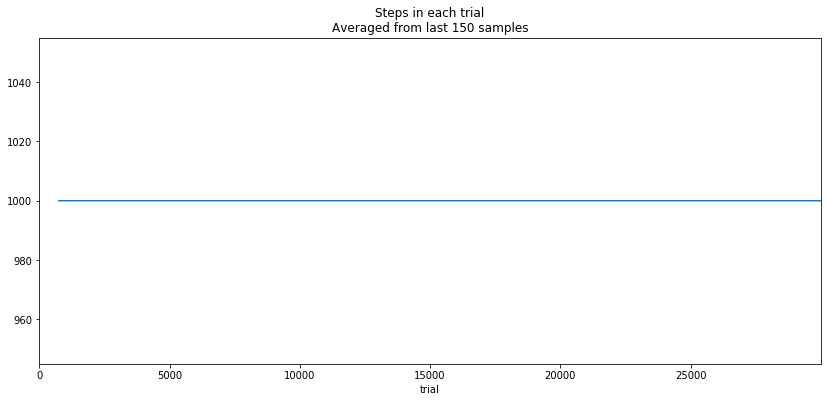

In [16]:
metrics_df['steps_in_trial'].rolling(window=avg_window).mean().plot(figsize=(14,6), title=f'Steps in each trial\nAveraged from last {avg_window} samples');

### Average fitness

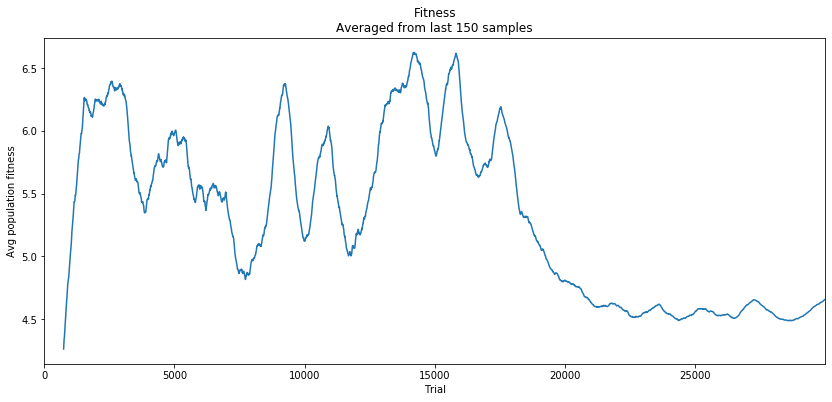

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))

metrics_df['avg_fitness'].rolling(window=avg_window).mean().plot(ax=ax)

ax.set_title(f'Fitness\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Avg population fitness')

plt.show()

## Reward

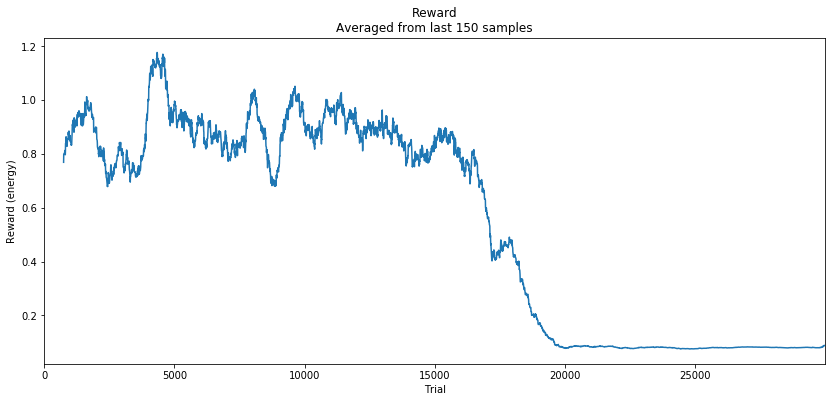

In [18]:
fig, ax = plt.subplots(figsize=(14, 6))

metrics_df['reward'].rolling(window=avg_window).mean().plot(ax=ax)

ax.set_title(f'Reward\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Reward (energy)')

plt.show()

## Classifiers

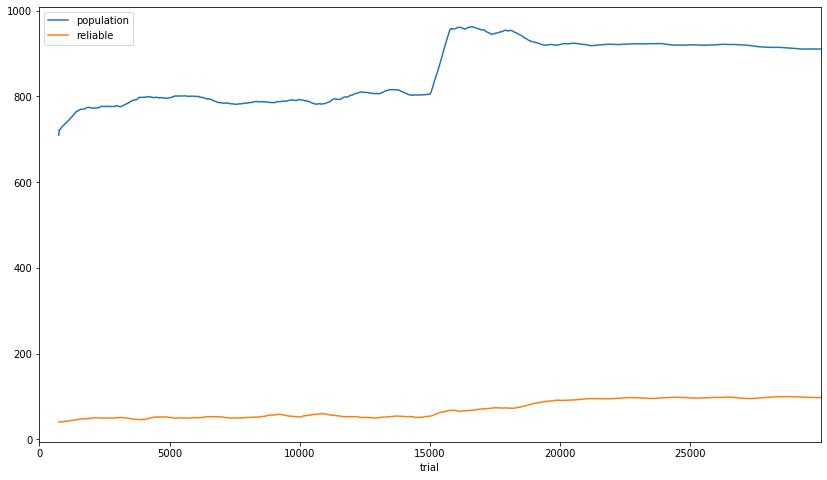

In [19]:
fig, ax = plt.subplots(figsize=(14,8))

metrics_df['population'].rolling(window=avg_window).mean().plot(label='population', ax=ax)
metrics_df['reliable'].rolling(window=avg_window).mean().plot(label='reliable', ax=ax)

plt.legend()
plt.show()

## Policy plot

In [20]:
obs = ("1","1")

def best_action(obs, population):
    matchset = population.form_match_set(Perception(obs))
    anticipated_change_cls = [cl for cl in matchset if cl.does_anticipate_change()]

    best_classifier = None
    if len(anticipated_change_cls) > 0:
        random.shuffle(anticipated_change_cls)
        best_classifier = max(anticipated_change_cls, key=lambda cl: cl.fitness * cl.num)

    if best_classifier is not None:
        return best_classifier.action
    else:
        return None
    
a = best_action(obs, population)
print(a)

2


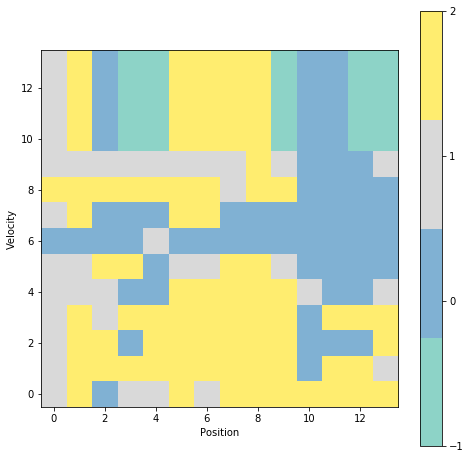

In [21]:
cmap = cm.get_cmap('Set3', 4)

BINS = 14
EMPTY = -1

policy = np.full((BINS, BINS), EMPTY)

for pos_bin in range(BINS):
    for vel_bin in range(BINS):
        obs = (str(pos_bin), str(vel_bin))
        action = best_action(obs, population)
        policy[pos_bin, vel_bin] = action if action != None else EMPTY
        
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(policy, interpolation='none', cmap=cmap);
ax.invert_yaxis()

fig.colorbar(im, ticks=[-1, 0, 1, 2])
plt.xlabel('Position')
plt.ylabel('Velocity')


plt.show();

## Save objects for reproduction

In [22]:
filename = f'energy_mountain_car_{trials}_trials_decay_{decay}_bins_{bins}.pickle'
with open(filename, 'wb') as f:
    pickle.dump((population, metrics_df), f)

## Exploitation

In [23]:
%%time

exploiter = ACS2(cfg, population)
population_exploit, metrics_exploit = agent.exploit(env, 500)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1000, 'reward': 0.3078269329714706, 'avg_fitness': 4.6828940992292925, 'population': 911, 'numerosity': 7030, 'reliable': 98}
INFO:lcs.agents.Agent:{'trial': 50, 'steps_in_trial': 1000, 'reward': 0.07415479196770305, 'avg_fitness': 4.6994451662306185, 'population': 911, 'numerosity': 7030, 'reliable': 98}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 1000, 'reward': 0.31890772264192246, 'avg_fitness': 4.699827921438007, 'population': 911, 'numerosity': 7030, 'reliable': 98}
INFO:lcs.agents.Agent:{'trial': 150, 'steps_in_trial': 1000, 'reward': 0.09029781247273551, 'avg_fitness': 4.698310726278206, 'population': 911, 'numerosity': 7030, 'reliable': 98}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 1000, 'reward': 0.29217443409976995, 'avg_fitness': 4.6982998186302405, 'population': 911, 'numerosity': 7030, 'reliable': 98}
INFO:lcs.agents.Agent:{'trial': 250, 'steps_in_trial': 1000, 'reward': 0.07210765573441587, 'avg

CPU times: user 13min 52s, sys: 1.49 s, total: 13min 53s
Wall time: 13min 55s


In [24]:
metrics_exploit_df = pd.DataFrame(metrics_exploit)
metrics_exploit_df.set_index('trial', inplace=True)

metrics_exploit_df.tail()

,steps_in_trial,reward,avg_fitness,population,numerosity,reliable
trial,,,,,,
475,1000,0.068225,4.699221,911,7030,98
480,1000,0.074928,4.699178,911,7030,98
485,1000,0.086222,4.698809,911,7030,98
490,1000,0.067911,4.699478,911,7030,98
495,1000,0.294804,4.699495,911,7030,98


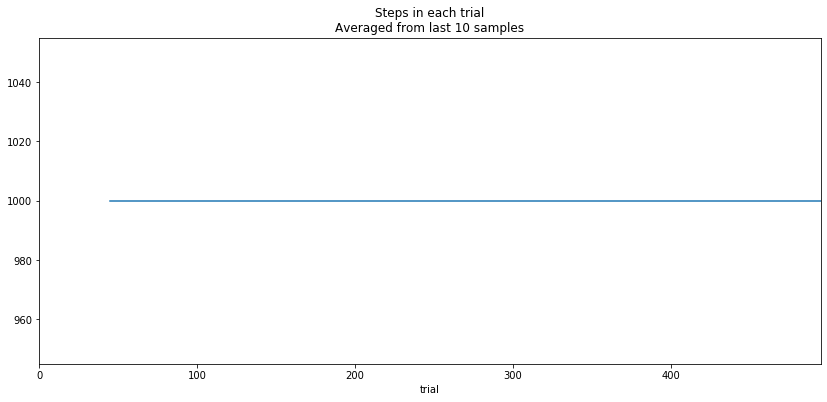

In [25]:
metrics_exploit_df['steps_in_trial'].rolling(window=10).mean().plot(figsize=(14,6), title=f'Steps in each trial\nAveraged from last 10 samples');

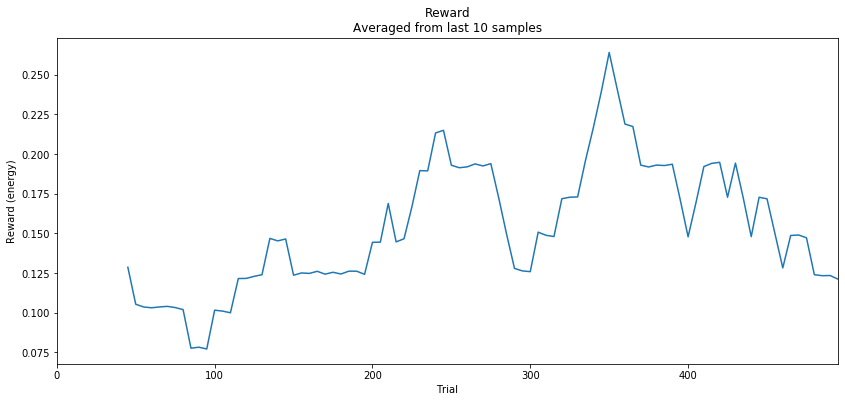

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

metrics_exploit_df['reward'].rolling(window=10).mean().plot(ax=ax)

ax.set_title(f'Reward\nAveraged from last 10 samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Reward (energy)')

plt.show()